# Optimization of spatial infraestructure for EV charging

## II. General formulation
$$ min \sum_{i,j} c_{ij} \Pi_{ij} $$

Subject to:

$$ \sum_{j} \Pi_{ij} = q_{i} $$
$$ \sum_{i} \Pi_{ij} = s_{i}$$

TyPical cost function:
$$C = (c_{ij})$$
Where c is a convex function, i.e.: the distance between station location and demand location in some norm:
$$c_{ij} = c(x_{i}, y_{j}) = |x_{i} - y_{j}|$$

In [6]:
import Pkg;
Pkg.rm("Mosek");
Pkg.rm("MosekTools");
Pkg.gc();

    Updating `C:\Users\Equipo\Documents\GitHub\MATE\Project.toml`
  [6405355b] - Mosek v1.2.2
  No Changes to `C:\Users\Equipo\Documents\GitHub\MATE\Manifest.toml`
    Updating `C:\Users\Equipo\Documents\GitHub\MATE\Project.toml`
  [1ec41992] - MosekTools v0.11.0
    Updating `C:\Users\Equipo\Documents\GitHub\MATE\Manifest.toml`
  [6405355b] - Mosek v1.2.2
  [1ec41992] - MosekTools v0.11.0
  [1b915085] - WinReg v0.3.1
      Active manifest files: 4 found
      Active artifact files: 164 found
      Active scratchspaces: 11 found
     Deleted no artifacts, repos, packages or scratchspaces


In [12]:
import Pkg;
Pkg.add("Mosek")
Pkg.build("Mosek")
Pkg.add("MosekTools")
Pkg.build("MosekTools")

   Resolving package versions...
  No Changes to `C:\Users\Equipo\Documents\GitHub\MATE\Project.toml`
  No Changes to `C:\Users\Equipo\Documents\GitHub\MATE\Manifest.toml`
    Building Mosek → `C:\Users\Equipo\.julia\scratchspaces\44cfe95a-1eb2-52ea-b672-e2afdf69b78f\fd5095fff9938c5b23bdf7ffb91a976932d5bc61\build.log`
   Resolving package versions...
  No Changes to `C:\Users\Equipo\Documents\GitHub\MATE\Project.toml`
  No Changes to `C:\Users\Equipo\Documents\GitHub\MATE\Manifest.toml`
    Building Mosek → `C:\Users\Equipo\.julia\scratchspaces\44cfe95a-1eb2-52ea-b672-e2afdf69b78f\fd5095fff9938c5b23bdf7ffb91a976932d5bc61\build.log`


General declarations and functions:

In [13]:
using JuMP, GLPK, Mosek
using VoronoiCells, GeometryBasics, Plots
using Random
using Statistics

┌ Info: Precompiling Mosek [6405355b-0ac2-5fba-af84-adbd65488c0e]
└ @ Base loading.jl:1342


In [14]:
using MosekTools

┌ Info: Precompiling MosekTools [1ec41992-ff65-5c91-ac43-2df89e9693a4]
└ @ Base loading.jl:1342


In [15]:
function get_cost_matrix(x, y, norm=2)    
    m = size(x)[1]
    n = size(y)[1]
    #Calculo los costos Cij = |xi-yj| (distancia euclidea en R^2)
    c1 = (x[:,1]*ones(1,n) - ones(m,1)*y[:,1]').^norm
    c2 = (x[:,2]*ones(1,n) - ones(m,1)*y[:,2]').^norm
    return (c1+c2).^(1/norm)
end

get_cost_matrix (generic function with 2 methods)

In [53]:
function plot_assignments(x, y, Pi, voronoi = true)
    gr()
    Plots.GRBackend()

    # Define m and n
    m = size(x)[1]
    n = size(y)[1]

    # Create Stations List
    #if k == n
    points = [Point2(y[i,1], y[i,2]) for i in 1:n] 
    #else
       #ver en el 
    #end

    # Voronoi Cells
    rect = Rectangle(Point2(0, 0), Point2(1, 1))
    tess = voronoicells(points, rect);

    #Assigments
    assigned_index = [argmax(Pi[i,:]) for i in 1:m];
    
    #Array of arrays. Each array is the amount of cars that go on a particular station
    X = [ x[findall(x->x==i, assigned_index),1] for i in 1:n];
    Y = [ x[findall(x->x==i, assigned_index),2] for i in 1:n];

    
    scatter(X, Y, aspect_ratio=:equal, markersize = 3, legend = :outertopright ) # Plot EVs (differente color by each Station)
    
    if voronoi == true
        plot!(tess, color = :black)
    end
    
    scatter!(y[:,1], y[:,2], markersize = 6, label = "Stations", markershape = :star) # Plot Stations
    annotate!([(points[i][1] + 0.02, points[i][2] + 0.03, text(i, :black)) for i in 1:n]) # Add Station Number
end

plot_assignments (generic function with 2 methods)

In [54]:
m = 1000; # Demand locations count
n = 10; # Station locations count
norm = 2; # Manhattan Metric

In [153]:
x = sortslices(rand(m,2), dims = 1); # TODO: Ver alguna distribución para los EVs (no uniformes, ej: normal, restringida al cuadrado?)
y = sortslices(rand(n,2), dims = 1);
C = get_cost_matrix(x, y, norm); # Matriz de costos
q = ones(m,1);

## III. Optmial transport for fixed locations
We assume that the station locations $\{ y_j \}$ have already been selected

### A. Free Capacities

We assume that the station locations $\{ y_j \}$ have already been selected, and their supply capacities can be arbitrarly chosen.

In [19]:
model = JuMP.Model(GLPK.Optimizer)

@variable(model,Pi[1:m,1:n]>=0)

@constraint(model, sum(Pi, dims=2) .== q)

@objective(model,Min, sum( C.*Pi ))

#print(model)
model;

In [20]:
optimize!(model)

In [21]:
s = sum(value.(Pi), dims=1)'

10×1 adjoint(::Matrix{Float64}) with eltype Float64:
 128.0
 256.0
 102.0
  59.0
  24.0
  87.0
 134.0
  90.0
  78.0
  42.0

In [56]:
# Graficar la asignacion
Pi = value.(Pi) 
plot_assignments(x, y, Pi)

LoadError: BoundsError: attempt to access 10×2 Matrix{Float64} at index [[1, 2, 4, 6, 12, 17, 18, 20, 23, 26  …  442, 444, 449, 459, 463, 465, 467, 470, 481, 483], 2]

### B. Fixed Capacities

#### Simple discrete counterexample
$$C = \begin{bmatrix}
1 & 3\\
3 & 1
\end{bmatrix}$$

$$q = \begin{bmatrix}
1\\
2
\end{bmatrix}$$

$$s = \begin{bmatrix}
2 & 1
\end{bmatrix}$$

Then:

$$\Pi^{*} = \begin{bmatrix}
1 & 0\\
1 & 1
\end{bmatrix}$$

In [23]:
C1 = [1 3; 3 1]
q1 = [1; 2]
s = [2 1]


model = JuMP.Model(GLPK.Optimizer)

@variable(model,Pi[1:2, 1:2] >=0 )
@constraint(model, sum(Pi, dims=2) .== q1)
@constraint(model, sum(Pi, dims=1) .== s )

@objective(model,Min, sum( C1.*Pi ))

#print(model)
model

optimize!(model)
value.(Pi)

2×2 Matrix{Float64}:
 1.0  0.0
 1.0  1.0

#### Proposition 1

Suppose:

* Más ubicaciones de demanda, que estaciones: $m \ge n$
* Demandas unitarias: $q_{i} = 1$, $i = 1, ..., m$
* Capacidad justa: $s_{j} \in Z, s_{j} > 0, \sum_{j} s_{j} = m$

Then: 

La solución óptima $\Pi^{*}$ debe ser de ceros y unos ($\Pi_{ij} \in \{ 0, 1\}$)


In [24]:
#Vector de capacidades
aux = rand(n,1); #random proportion for s
s = round.(aux/sum(aux)*m); #normalization
s[argmax(s)] += (m - sum(s)); #error correction
s

10×1 Matrix{Float64}:
 197.0
 144.0
  82.0
  78.0
  39.0
 160.0
 137.0
  21.0
  55.0
  87.0

In [25]:
model = JuMP.Model(GLPK.Optimizer)

@variable(model,Pi[1:m,1:n]>=0)

@constraint(model, sum(Pi, dims=2) .== q)
@constraint(model, sum(Pi, dims=1) .== 100*ones(n,1)' ) #FIXME: El s_max es el mismo en todas las estaciones (Ilustra mejor)

@objective(model,Min, sum( C.*Pi ))

#print(model)
model;

In [26]:
optimize!(model)
value.(Pi);

In [27]:
#[TODO] Find values not in 0 or 1 to verify
#find(value.(Pi) != 0 || value.(Pi) != 1);

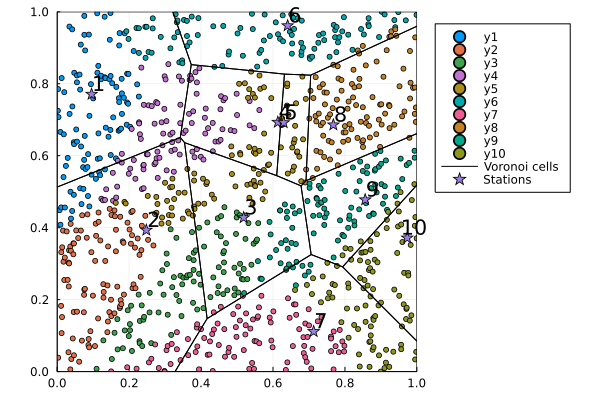

In [28]:
# Graficar la asignacion
Pi = value.(Pi) 
plot_assignments(x, y, Pi)

#### Case m = n

In [29]:
m2 = 10; # Demand locations count
n2 = 10; # Station locations count

x2 = sortslices(rand(m2,2), dims = 1);
y2 = sortslices(rand(n2,2), dims = 1);
C2 = get_cost_matrix(x2, y2, norm); #Matriz de costos
q2 = ones(m2,1);

#Vector de capacidades
s2 = ones(n2,1); 

In [30]:
model = JuMP.Model(GLPK.Optimizer)

@variable(model,Pi[1:m2,1:n2]>=0)

@constraint(model, sum(Pi, dims=2) .== q2)
@constraint(model, sum(Pi, dims=1) .== s2' )

@objective(model,Min, sum( C2.*Pi ))

#print(model)
model;

In [31]:
optimize!(model)
value.(Pi);

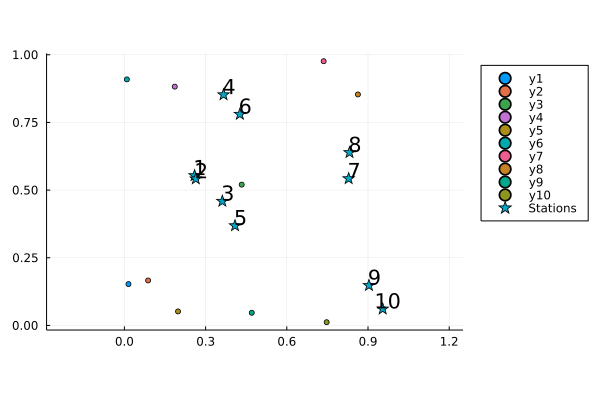

In [32]:
# Graficar la asignacion
Pi = value.(Pi) 
plot_assignments(x2, y2, Pi, false)

In [33]:
#Vector de capacidades
s = sum(value.(Pi), dims=1)'

10×1 adjoint(::Matrix{Float64}) with eltype Float64:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

### C. Constrained capacities

We assume that the station locations $\{ y_j \}$ have already been selected, and their supply capacities can be arbitrarly chosen.

#### Proposition 2

Suppose:

* Más ubicaciones de demanda, que estaciones: $m \ge n$
* Demandas unitarias: $q_{i} = 1$, $i = 1, ..., m$
* Capacidades topeadas (aseguran demanda): $\overline{s}_{j} \in Z, s_{j} > 0, \sum_{j} \overline{s}_{j} \ge m$

Then: 

La solución óptima $\Pi^{*}$ debe ser de ceros y unos ($\Pi_{ij} \in \{ 0, 1\}$)


In [34]:
#Vector de cotas de capacidad
aux = rand(n,1); #random proportion for s
tolerance = 0.2; 
s_max = round.(aux/sum(aux)*m*(1+tolerance)) #normalization

10×1 Matrix{Float64}:
  23.0
 206.0
  76.0
 144.0
  17.0
 173.0
  85.0
 190.0
 186.0
 101.0

In [35]:
sum(s_max)

1201.0

In [36]:
model = JuMP.Model(GLPK.Optimizer)

@variable(model,Pi[1:m,1:n]>=0)

@constraint(model, sum(Pi, dims=2) .== q)
@constraint(model, sum(Pi, dims=1) .<= 120*ones(n,1)') #s_max' )

@objective(model,Min, sum( C.*Pi ))

#print(model)
model;

In [37]:
optimize!(model)

In [38]:
value.(Pi);

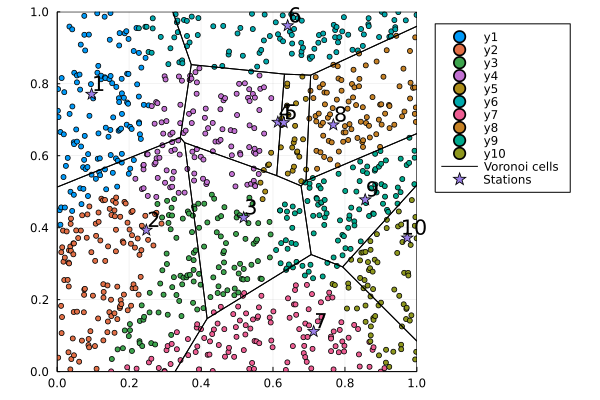

In [39]:
# Graficar la asignacion
Pi = value.(Pi) 
plot_assignments(x, y, Pi)

#### Penalized capacities

Suppose, instead, that one is designing an installation with known locations but still has not defined the relevant capacities. Leaving them complete free may be undesirable, but one could seek to even out the allocation somewhat between locations.

With this aim, we consider a problem where a soft penalty term to the transport cost:

$$ min \sum_{ij} c_{ij} \Pi_{ij} + \epsilon \sum_{j} \phi_{j}(s_{j})$$

Subject to:

$$\sum_{j} \Pi_{ij} = q_{i}$$
$$\sum_{i} \Pi_{ij} = s_{j}$$

In this case, we use $\phi_{j}(s) = \frac{1}{2}s^{2}$

In [40]:
function phi(s)
    return 0.5*(s.^2)
end

phi (generic function with 1 method)

In [41]:
using Ipopt
epsilon = 0

model = JuMP.Model(Ipopt.Optimizer)

@variable(model, Pi[1:m,1:n]>=0)
@variable(model, s[1:n]>=0)

@constraint(model, sum(Pi, dims=2) .== q)
@constraint(model, sum(Pi, dims=1) .== s')

@objective(model,Min, sum( C.*Pi ) + epsilon*sum(phi(s)));


In [42]:
optimize!(model)
value.(Pi), objective_value(model)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    20010
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:    10010
                     variables with only lower bounds:    10010
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equal

([1.0000000500383008 0.0 … 0.0 0.0; 1.0000000524298565 0.0 … 0.0 0.0; … ; 0.0 0.0 … 4.420055563732717e-9 0.0; 0.0 0.0 … 6.4259997300778304e-9 1.0000000337859003], 158.70930045584615)

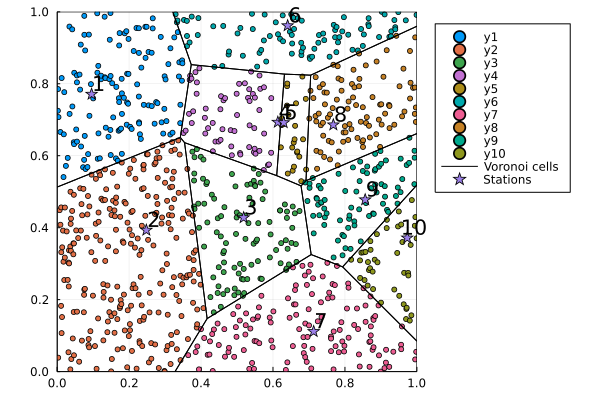

In [43]:
# Graficar la asignacion
Pi = value.(Pi) 
plot_assignments(x, y, Pi)

## IV. Location Selection
In this section we consider the situation where the location poitns are also part of the design.

### A. Free locations

[TODO] K - Means

### B. Sparse selection over a set of candidate locations

Example 1 - Verification

$$x = y = \begin{bmatrix}
1\\
2\\
5
\end{bmatrix}$$

Then:

$$C = \begin{bmatrix}
0 & 1 & 4\\
1 & 0 & 3\\
4 & 3 & 0
\end{bmatrix}$$

$$q = \begin{bmatrix}
2\\
3\\
1
\end{bmatrix}$$

$$\overline{s} = \begin{bmatrix}
s & s & s
\end{bmatrix}$$

Case 1: s = 5

In [44]:
model = JuMP.Model(GLPK.Optimizer)

@variable(model,Pi[1:m,1:n]>=0)

@constraint(model, sum(Pi, dims=2) .== q)
@constraint(model, sum(Pi, dims=1) .<= s_max' )

@objective(model,Min, sum( C.*Pi ));

In [45]:
optimize!(model)
value.(Pi), objective_value(model);

Case 2: s = 4

### MILP (Mixed-integer linear programming)

$$min \sum_{ij} c_{ij} \Pi_{ij}$$

Subject to:

$$\sum_{j} \Pi_{ij} = q_i$$
$$\sum_{i} \Pi_{ij} \le b_{j}\overline{s}_{j}$$
$$\sum_{j} b_{j} \le k$$
$$b_{j} \in \{ 0, 1\}$$

Where: 

$b_{j}$ indicates whether station $y_{j}$ is active or not

$k$ is the count of active actions

In [179]:
k = 4
q = 1*ones(m,1)
s_max = 250*1.2*ones(n,1);
# Validar que la cantidad de prendidos, con la capacidad q, den para cubrir todos los EVs

In [180]:
model = JuMP.Model(Mosek.Optimizer)
#model = JuMP.Model(GLPK.Optimizer)

@variable(model,Pi[1:m,1:n]>=0)
@variable(model, b[1:n], Bin)

@constraint(model, sum(Pi, dims=2).== q)
@constraint(model, sum(Pi, dims=1)' .<= (b.*s_max) )
@constraint(model, sum(b) <= k)

@objective(model,Min, sum( C.*Pi ));

In [181]:
optimize!(model)
objective_value(model)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 1011            
  Cones                  : 0               
  Scalar variables       : 10010           
  Matrix variables       : 0               
  Integer variables      : 10              

Optimizer started.
Mixed integer optimizer started.
Threads used: 4
Presolve started.
Presolve terminated. Time = 0.03
Presolved problem: 10010 variables, 1011 constraints, 20020 non-zeros
Presolved problem: 0 general integer, 10 binary, 10000 continuous
Clique table size: 0
BRANCHES RELAXS   ACT_NDS  DEPTH    BEST_INT_OBJ         BEST_RELAX_OBJ       REL_GAP(%)  TIME  
0        1        1        0        NA                   1.6322493869e+02     NA          0.1   
0        1        1        0        2.2037960839e+02     1.6322493869e+02     25.93       0.1   
Cut generation started.
0        1        1        0    

214.78450691222264

In [182]:
value.(Pi)
# Verificar la asignación Pi

1000×10 Matrix{Float64}:
  0.0          1.0  0.0  0.0  0.0  …   0.0         0.0  0.0   0.0
  0.0          1.0  0.0  0.0  0.0      0.0         0.0  0.0   0.0
  0.0          1.0  0.0  0.0  0.0      0.0         0.0  0.0   0.0
  0.0          1.0  0.0  0.0  0.0      0.0         0.0  0.0   0.0
  0.0          1.0  0.0  0.0  0.0      0.0         0.0  0.0   0.0
  0.0          0.0  1.0  0.0  0.0  …   0.0         0.0  0.0   0.0
  0.0          1.0  0.0  0.0  0.0      0.0         0.0  0.0   0.0
  0.0          1.0  0.0  0.0  0.0      0.0         0.0  0.0   0.0
  0.0          1.0  0.0  0.0  0.0      0.0         0.0  0.0   0.0
  0.0          0.0  1.0  0.0  0.0      0.0         0.0  0.0   0.0
  0.0          1.0  0.0  0.0  0.0  …   0.0         0.0  0.0   0.0
  0.0          0.0  1.0  0.0  0.0      0.0         0.0  0.0   0.0
 -5.12739e-14  0.0  1.0  0.0  0.0      0.0         0.0  0.0   0.0
  ⋮                                ⋱                         
  0.0          0.0  0.0  0.0  1.0      0.0         0.0 

In [183]:
value.(b)

10-element Vector{Float64}:
 0.0
 1.0
 1.0
 0.0
 1.0
 4.163336342344337e-17
 0.0
 1.0
 0.0
 0.0

In [192]:
function delete_row(matrix, row_index)
    
    return matrix[setdiff(1:end, row_index), :];
    
end


function plot_assignments_2(x, y, Pi, b)
    gr()
    Plots.GRBackend()

    # Define m and n
    m = size(x)[1]
    n = size(y)[1]

    k = Int(sum(b));
    
    #Points of availabile stations
    points = [Point2(y[i,1], y[i,2]) for i in 1:n]
    
    not_available_stations_index = findall(x -> x <= 0.5, b)
   
    deleteat!(points, not_available_stations_index)


    # Voronoi Cells
    rect = Rectangle(Point2(0, 0), Point2(1, 1))
    tess = voronoicells(points, rect);

    #Assigments
    assigned_index = [argmax(Pi[i,:]) for i in 1:m];
    
    #Array of arrays. Each array is the amount of cars that go on a particular station
    X = [ x[findall(x->x==i, assigned_index),1] for i in 1:n];
    Y = [ x[findall(x->x==i, assigned_index),2] for i in 1:n];

    
    #Plot cars locations
    scatter(X, Y, aspect_ratio=:equal, markersize = 3, legend = :outertopright ) # Plot EVs (differente color by each Station)
    
    #Plot voronoi lines
    plot!(tess, color = :black)
    
 
    #Plot available stations locations
    available_stations_positions = y;
    
    available_stations_positions = delete_row(available_stations_positions, not_available_stations_index)
      
    scatter!(available_stations_positions[:,1], available_stations_positions[:,2], markersize = 6, label = "Stations", markershape = :star) # Plot Stations
    
    
    #Plot available stations number text
    available_stations_index = findall(x -> x > 0.5, b)
    
    annotate!([(points[i][1] + 0.02, points[i][2] + 0.03, text(available_stations_index[i], :black)) for i in 1:k]) # Add Station Number
end

plot_assignments_2 (generic function with 1 method)

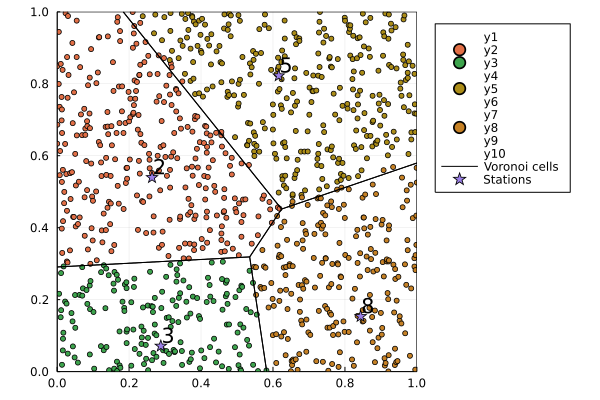

In [193]:
# Graficar la asignacion
Pi = value.(Pi) 
b = value.(b)
plot_assignments_2(x, y, Pi, b)

In [152]:
s = sum(round.(value.(Pi)), dims=1)'

10×1 adjoint(::Matrix{Float64}) with eltype Float64:
 173.0
 300.0
   0.0
   0.0
   0.0
   0.0
 227.0
 300.0
   0.0
   0.0

In [198]:
function Solve_MILP(k, C)

    m = size(C)[1];
    n = size(C)[2];

    q = 1.0 * ones(m,1);
    
    tolerance = 20;
    
    s_max = (m / k) * (1 + tolerance / 100) * ones(n,1);

    model = JuMP.Model(Mosek.Optimizer);

    @variable(model,Pi[1:m,1:n] >= 0)
    @variable(model, b[1:n], Bin)

    @constraint(model, sum(Pi, dims=2).== q)
    @constraint(model, sum(Pi, dims=1)' .<= (b.*s_max) )
    @constraint(model, sum(b) <= k)

    @objective(model, Min, sum( C.*Pi ));

    optimize!(model);

    return objective_value(model);
    
end

Solve_MILP (generic function with 1 method)

In [203]:
cost_per_k = zeros(n);

for k in 1:n
    cost = Solve_MILP(k, C);
    cost_per_k[k] = cost;
end

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 1011            
  Cones                  : 0               
  Scalar variables       : 10010           
  Matrix variables       : 0               
  Integer variables      : 10              

Optimizer started.
Mixed integer optimizer started.
Threads used: 4
Presolve started.
Presolve terminated. Time = 0.05
Presolved problem: 10010 variables, 1011 constraints, 20020 non-zeros
Presolved problem: 0 general integer, 10 binary, 10000 continuous
Clique table size: 1
BRANCHES RELAXS   ACT_NDS  DEPTH    BEST_INT_OBJ         BEST_RELAX_OBJ       REL_GAP(%)  TIME  
0        1        1        0        NA                   1.6322493869e+02     NA          0.1   
0        1        1        0        4.3693137691e+02     1.6322493869e+02     62.64       0.1   
Cut generation started.
0        1        1        0    


Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 1011            
  Cones                  : 0               
  Scalar variables       : 10010           
  Matrix variables       : 0               
  Integer variables      : 10              

Optimizer started.
Mixed integer optimizer started.
Threads used: 4
Presolve started.
Presolve terminated. Time = 0.03
Presolved problem: 10010 variables, 1011 constraints, 20020 non-zeros
Presolved problem: 0 general integer, 10 binary, 10000 continuous
Clique table size: 0
BRANCHES RELAXS   ACT_NDS  DEPTH    BEST_INT_OBJ         BEST_RELAX_OBJ       REL_GAP(%)  TIME  
0        1        1        0        NA                   1.6322493869e+02     NA          0.1   
0        1        1        0        3.0506118843e+02     1.6322493869e+02     46.49       0.2   
Cut generation started.
0        1        1        0   

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 1011            
  Cones                  : 0               
  Scalar variables       : 10010           
  Matrix variables       : 0               
  Integer variables      : 10              

Optimizer started.
Mixed integer optimizer started.
Threads used: 4
Presolve started.
Presolve terminated. Time = 0.02
Presolved problem: 10010 variables, 1011 constraints, 20020 non-zeros
Presolved problem: 0 general integer, 10 binary, 10000 continuous
Clique table size: 0
BRANCHES RELAXS   ACT_NDS  DEPTH    BEST_INT_OBJ         BEST_RELAX_OBJ       REL_GAP(%)  TIME  
0        1        1        0        NA                   1.6331543518e+02     NA          0.1   
0        1        1        0        2.3377155891e+02     1.6331543518e+02     30.14       0.1   
Cut generation started.
0        1        1        0    

0        1        1        0        1.9493774097e+02     1.6714375124e+02     14.26       0.1   
0        1        1        0        1.8332023687e+02     1.6714375124e+02     8.82        0.2   
Cut generation started.
0        1        1        0        1.8332023687e+02     1.6714375124e+02     8.82        0.2   
0        2        1        0        1.8332023687e+02     1.7240347196e+02     5.96        0.2   
0        3        1        0        1.8332023687e+02     1.7551786228e+02     4.26        0.3   
0        4        1        0        1.8332023687e+02     1.7652340014e+02     3.71        0.3   
0        5        1        0        1.8332023687e+02     1.7771687342e+02     3.06        0.3   
0        6        1        0        1.8332023687e+02     1.7814989918e+02     2.82        0.3   
Cut generation terminated. Time = 0.06
0        8        1        0        1.7873766403e+02     1.7829435752e+02     0.25        0.4   
0        11       1        0        1.7873766403e+02     1.78294

### Cost per station available

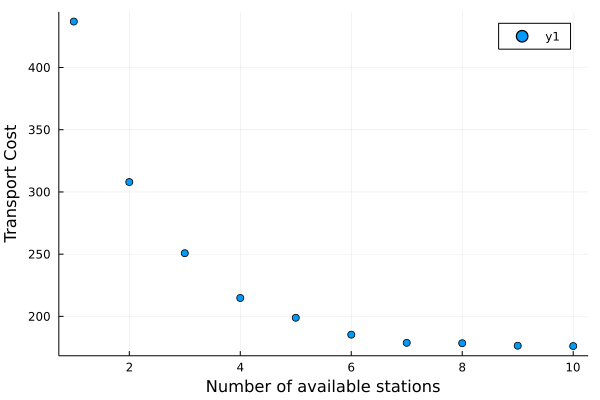

In [222]:
ks = [1:n];

scatter(ks, cost_per_k, xaxis = "Number of available stations", yaxis = "Transport Cost")

### Marginal cost for adding a station

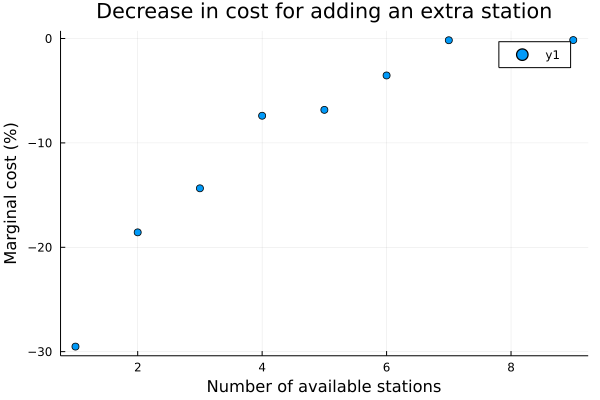

In [221]:
marginal_cost = diff(cost_per_k);



marginal_cost_percentage = 100 * (marginal_cost ./ cost_per_k[1:n-1]);

ks = [1:n-1];

scatter(ks, marginal_cost_percentage, xaxis = "Number of available stations", yaxis = "Marginal cost (%)", title = "Decrease in cost for adding an extra station")